# Figures for Future Variants
This notebook reproduces the figure generation pipeline from `figures_for_results.ipynb`,
but it only loads the original pulse and the CMA-ES adiabatic variants (
`adiabatic`, `alt_adiabatic_1`, `alt_adiabatic_2`). Make sure the optimization
notebook has produced the required artifacts under `notebooks/results/CMA-ES` before running this notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qutip as qt
from matplotlib.lines import Line2D
from pathlib import Path
from collections import defaultdict
from warnings import warn
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

In [3]:
BASE_DIR = Path('/home/yehon/projects/grape-crab-qoc')
RESULT_DIRS = {
    'CMA-ES': BASE_DIR / 'notebooks' / 'results' / 'CMA-ES',
}
OUTPUT_DIR = BASE_DIR / 'results' / 'disscution'

CANONICAL_DURATION = 0.1
CANONICAL_POINTS = 2000
CANONICAL_T = np.linspace(0.0, CANONICAL_DURATION, CANONICAL_POINTS)

TARGETS = ['original', 'adiabatic', 'alt_adiabatic_1', 'alt_adiabatic_2']
TARGET_ALIASES = {
    'original': ['original', 'baseline'],
    'adiabatic': ['adiabatic', 'adiab'],
    'alt_adiabatic_1': ['alt_adiabatic_1', 'alt1', 'adiabatic1'],
    'alt_adiabatic_2': ['alt_adiabatic_2', 'alt2', 'adiabatic2'],
}
CHANNELS = ['omega', 'delta']
CHANNEL_ALIASES = {
    'omega': ['omega'],
    'delta': ['delta'],
}

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Artifacts will be written to: {OUTPUT_DIR}')

Artifacts will be written to: /home/yehon/projects/grape-crab-qoc/results/disscution


In [4]:
COLOR_MAP = {
    'original': '#1f77b4',
    'adiabatic': '#2ca02c',
    'alt_adiabatic_1': '#ff7f0e',
    'alt_adiabatic_2': '#9467bd',
}

TARGET_DISPLAY_NAMES = {
    'original': 'Original',
    'adiabatic': 'Adiabatic',
    'alt_adiabatic_1': 'Alt Adiabatic 1',
    'alt_adiabatic_2': 'Alt Adiabatic 2',
}

TIME_LABEL = r'Time ($\mu s$)'

def color_for_target(target: str) -> str:
    return COLOR_MAP.get(target, '#333333')

def display_name(target: str) -> str:
    return TARGET_DISPLAY_NAMES.get(target, target.title())

In [5]:
def iter_pulse_files(directory: Path):
    for path in directory.glob('*.npy'):
        if path.is_file():
            yield path


def resolve_pulse_file(directory: Path, target: str, channel: str) -> Path:
    target_aliases = [alias.lower() for alias in TARGET_ALIASES[target]]
    channel_aliases = [alias.lower() for alias in CHANNEL_ALIASES[channel]]
    for pulse_path in iter_pulse_files(directory):
        name = pulse_path.name.lower()
        if any(alias in name for alias in target_aliases) and any(alias in name for alias in channel_aliases):
            return pulse_path
    target_desc = ', '.join(target_aliases)
    channel_desc = ', '.join(channel_aliases)
    raise FileNotFoundError(f'No {channel} pulse for target "{target}" (aliases: {target_desc}) in {directory}')


def load_and_resample(path: Path, canonical_t: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    raw = np.load(path)
    if raw.ndim != 1:
        raise ValueError(f'Expected 1D pulse in {path}, received shape {raw.shape}')
    original_t = np.linspace(canonical_t[0], canonical_t[-1], raw.size)
    resampled = np.interp(canonical_t, original_t, raw)
    return raw, resampled


def scale_pulses(omega: np.ndarray, delta: np.ndarray, canonical_t: np.ndarray) -> tuple[float, np.ndarray, np.ndarray, float, float]:
    area = np.trapezoid(omega, canonical_t)
    if np.isclose(area, 0.0):
        warn('Omega area is approximately zero; skipping rescale and leaving pulses unchanged.')
        scale = 1.0
    else:
        scale = 1.0 #4 * np.pi / area
    omega_scaled = omega * scale
    delta_scaled = delta# * scale
    scaled_area = np.trapezoid(omega_scaled, canonical_t)
    return scale, omega_scaled, delta_scaled, area, scaled_area


def slugify(*parts: str) -> str:
    return '_'.join(part.lower().replace('-', '_') for part in parts)


In [6]:
resampled_pulses: dict[str, dict[str, dict[str, np.ndarray]]] = defaultdict(dict)
summary_rows: list[dict[str, float]] = []
missing_entries: list[str] = []

for algorithm, directory in RESULT_DIRS.items():
    if not directory.exists():
        warn(f'Skipping {algorithm}: directory {directory} not found.')
        continue
    for target in TARGETS:
        try:
            omega_path = resolve_pulse_file(directory, target, 'omega')
        except FileNotFoundError as exc:
            missing_entries.append(f'{algorithm} | {target} | omega')
            warn(str(exc))
            continue
        try:
            delta_path = resolve_pulse_file(directory, target, 'delta')
        except FileNotFoundError as exc:
            missing_entries.append(f'{algorithm} | {target} | delta')
            warn(str(exc))
            continue

        _, omega_resampled = load_and_resample(omega_path, CANONICAL_T)
        _, delta_resampled = load_and_resample(delta_path, CANONICAL_T)

        scale, omega_scaled, delta_scaled, area_before, area_after = scale_pulses(
            omega_resampled, delta_resampled, CANONICAL_T
        )

        resampled_pulses[algorithm][target] = {
            'omega': omega_scaled,
            'delta': delta_scaled,
            'scale_factor': scale,
            'area_before': area_before,
            'area_after': area_after,
        }

        summary_rows.append(
            {
                'algorithm': algorithm,
                'target': target,
                'omega_file': omega_path.name,
                'delta_file': delta_path.name,
                'scale_factor': scale,
                'area_before': area_before,
                'area_after': area_after,
            }
        )

summary_df = pd.DataFrame(summary_rows)
summary_df

,algorithm,target,omega_file,delta_file,scale_factor,area_before,area_after
0,CMA-ES,original,Omega_Original.npy,Delta_Original_base.npy,1.0,12.566371,12.566371
1,CMA-ES,adiabatic,Omega_alt_adiabatic_2.npy,Delta_alt_adiabatic_1.npy,1.0,10.870596,10.870596
2,CMA-ES,alt_adiabatic_1,Omega_alt_adiabatic_1.npy,Delta_alt_adiabatic_1.npy,1.0,10.049376,10.049376
3,CMA-ES,alt_adiabatic_2,Omega_alt_adiabatic_2.npy,Delta_alt_adiabatic_2.npy,1.0,10.870596,10.870596


In [7]:
for algorithm, targets_dict in resampled_pulses.items():
    if not targets_dict:
        continue
    data = {'t': CANONICAL_T}
    for target, pulse_dict in targets_dict.items():
        slug = slugify(target)
        data[f'{slug}_omega'] = pulse_dict['omega']
        data[f'{slug}_delta'] = pulse_dict['delta']
    output_path = OUTPUT_DIR / f'{slugify(algorithm)}_rescaled_pulses.npz'
    np.savez(output_path, **data)
    print(f'Saved {output_path}')

summary_path = OUTPUT_DIR / 'pulse_scaling_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f'Saved {summary_path}')

if missing_entries:
    print('Missing pulse entries:')
    for item in missing_entries:
        print(f' - {item}')


Saved /home/yehon/projects/grape-crab-qoc/results/disscution/cma_es_rescaled_pulses.npz
Saved /home/yehon/projects/grape-crab-qoc/results/disscution/pulse_scaling_summary.csv


Saved overlay figure to /home/yehon/projects/grape-crab-qoc/results/disscution/pulse_overlay.png
Saved overlay figure to /home/yehon/projects/grape-crab-qoc/results/disscution/pulse_overlay.pdf


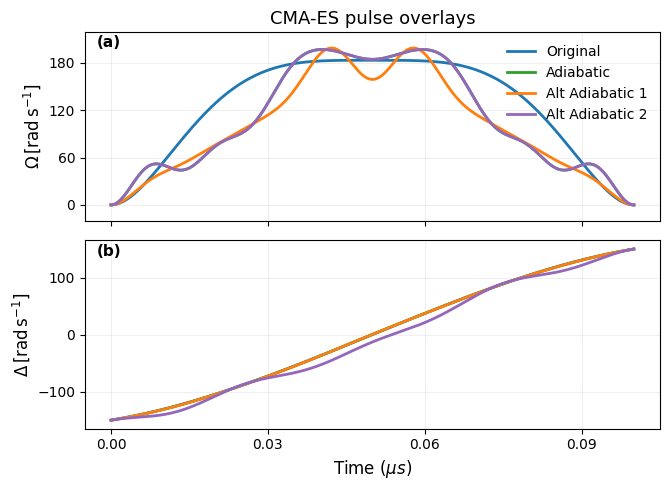

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(6.8, 5.0), sharex=True)

algorithm = 'CMA-ES'
algorithm_pulses = resampled_pulses.get(algorithm, {})

ylim_value_omega = 0.0
ylim_value_delta = 0.0

for target in TARGETS:
    pulse_entry = algorithm_pulses.get(target)
    if not pulse_entry:
        continue

    time_axis = CANONICAL_T
    omega_vals = pulse_entry['omega']
    delta_vals = pulse_entry['delta']

    axes[0].plot(time_axis, omega_vals, color=color_for_target(target), label=display_name(target), linewidth=2)
    axes[1].plot(time_axis, delta_vals, color=color_for_target(target), label=display_name(target), linewidth=2)

    ylim_value_omega = max(ylim_value_omega, float(np.max(np.abs(omega_vals))))
    ylim_value_delta = max(ylim_value_delta, float(np.max(np.abs(delta_vals))))

ylim_value_omega = ylim_value_omega if ylim_value_omega > 0 else 1.0
ylim_value_delta = ylim_value_delta if ylim_value_delta > 0 else 1.0

axes[0].set_ylim(-0.1 * ylim_value_omega, 1.1 * ylim_value_omega)
axes[1].set_ylim(-1.1 * ylim_value_delta, 1.1 * ylim_value_delta)

axes[0].set_title('CMA-ES pulse overlays', fontsize=13)
axes[0].set_ylabel(r'$\Omega\, [\mathrm{rad}\,\mathrm{s}^{-1}]$', fontsize=12)
axes[1].set_ylabel(r'$\Delta\, [\mathrm{rad}\,\mathrm{s}^{-1}]$', fontsize=12)
axes[1].set_xlabel(TIME_LABEL, fontsize=12)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    axes[0].legend(handles, labels, loc='upper right', frameon=False)

for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.grid(alpha=0.2)

axes[0].text(0.02, 0.92, '(a)', transform=axes[0].transAxes, fontsize=11, fontweight='bold')
axes[1].text(0.02, 0.92, '(b)', transform=axes[1].transAxes, fontsize=11, fontweight='bold')

fig.tight_layout()

overlay_path = OUTPUT_DIR / 'pulse_overlay.png'
fig.savefig(overlay_path, dpi=300, bbox_inches='tight')
print(f'Saved overlay figure to {overlay_path}')
overlay_pdf_path = OUTPUT_DIR / 'pulse_overlay.pdf'
fig.savefig(overlay_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved overlay figure to {overlay_pdf_path}')

Saved population trajectories to /home/yehon/projects/grape-crab-qoc/results/disscution/cma_es_population_trajectories.png and /home/yehon/projects/grape-crab-qoc/results/disscution/cma_es_population_trajectories.pdf


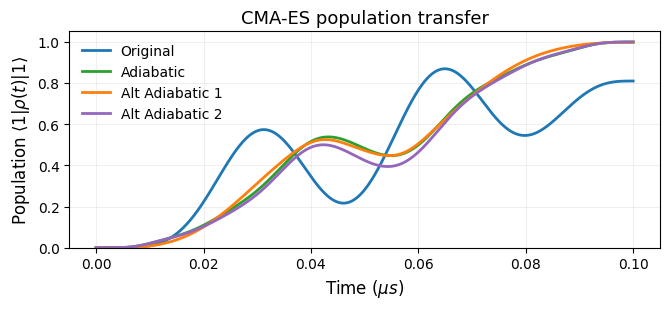

In [9]:
sx = qt.sigmax()
sz = qt.sigmaz()
ket0 = qt.basis(2, 0)
proj1 = qt.basis(2, 1) * qt.basis(2, 1).dag()

def make_interpolator(values: np.ndarray):
    values = np.asarray(values, dtype=float)
    def coefficient(t, _=None):
        return np.interp(t, CANONICAL_T, values)
    return coefficient

population_trajectories: dict[str, dict[str, np.ndarray]] = defaultdict(dict)
population_rows: list[dict[str, float]] = []

for algorithm, targets_dict in resampled_pulses.items():
    for target in TARGETS:
        pulse_entry = targets_dict.get(target)
        if not pulse_entry:
            continue

        omega = pulse_entry['omega']
        delta = pulse_entry['delta']
        hamiltonian = [
            [0.5 * sx, make_interpolator(omega)],
            [0.5 * sz, make_interpolator(delta)],
        ]

        result = qt.sesolve(hamiltonian, ket0, CANONICAL_T, e_ops=[proj1])
        population = np.clip(np.real(result.expect[0]), 0.0, 1.0)

        population_trajectories[algorithm][target] = population
        population_rows.append({
            'algorithm': algorithm,
            'target': target,
            'final_population': population[-1],
            'max_population': population.max(),
        })

population_fig, ax = plt.subplots(1, 1, figsize=(6.8, 3.2), sharex=True, sharey=True)
algorithm = 'CMA-ES'
trajectories = population_trajectories.get(algorithm, {})
for target in TARGETS:
    population = trajectories.get(target)
    if population is None:
        continue
    ax.plot(CANONICAL_T, population, color=color_for_target(target), label=display_name(target), linewidth=2)

ax.set_title('CMA-ES population transfer', fontsize=13)
ax.set_xlabel(TIME_LABEL, fontsize=12)
ax.set_ylabel(r'Population $\langle 1 | \rho(t) | 1 \rangle$', fontsize=12)
ax.set_ylim(0.0, 1.05)
ax.grid(alpha=0.2)
ax.legend(frameon=False)

population_fig.tight_layout()

pop_png = OUTPUT_DIR / 'cma_es_population_trajectories.png'
pop_pdf = OUTPUT_DIR / 'cma_es_population_trajectories.pdf'
population_fig.savefig(pop_png, dpi=300, bbox_inches='tight')
population_fig.savefig(pop_pdf, dpi=300, bbox_inches='tight')
print(f'Saved population trajectories to {pop_png} and {pop_pdf}')


Saved CMA-ES Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/disscution/cma_es_bloch_trajectories.png
Saved CMA-ES Bloch spheres to /home/yehon/projects/grape-crab-qoc/results/disscution/cma_es_bloch_trajectories.pdf


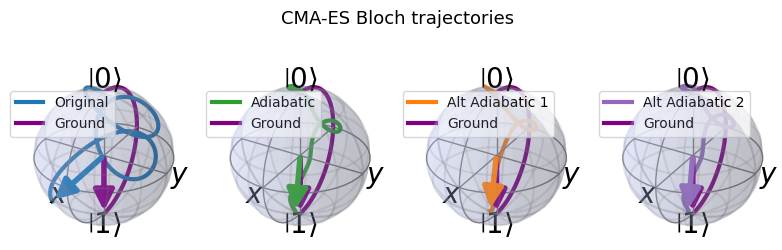

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

sy = qt.sigmay()
GROUND_COLOR = '#800080'


def simulate_bloch_trajectory(algorithm: str, target: str):
    pulses = resampled_pulses.get(algorithm, {}).get(target)
    if not pulses:
        return None

    omega = pulses['omega']
    delta = pulses['delta']

    hamiltonian = [
        [0.5 * sx, make_interpolator(omega)],
        [0.5 * sz, make_interpolator(delta)],
    ]

    result = qt.sesolve(hamiltonian, ket0, CANONICAL_T)
    states = result.states

    trajectory = {
        'sx': np.real(qt.expect(sx, states)),
        'sy': np.real(qt.expect(sy, states)),
        'sz': np.real(qt.expect(sz, states)),
    }

    field = np.vstack((omega, np.zeros_like(omega), delta))
    norms = np.linalg.norm(field, axis=0)
    ground_vec = np.zeros_like(field)
    mask = norms > 0
    ground_vec[:, mask] = -field[:, mask] / norms[mask]
    if np.any(~mask):
        ground_vec[:, ~mask] = np.array([[0.0], [0.0], [1.0]])

    trajectory['ground_sx'] = ground_vec[0]
    trajectory['ground_sy'] = ground_vec[1]
    trajectory['ground_sz'] = ground_vec[2]
    return trajectory


def plot_bloch_grid(algorithm: str):
    fig = plt.figure(figsize=(8.0, 2.6))
    axes = [
        fig.add_subplot(1, len(TARGETS), idx + 1, projection='3d')
        for idx in range(len(TARGETS))
    ]

    for idx, target in enumerate(TARGETS):
        ax = axes[idx]
        handles = []
        labels = []
        trajectory = simulate_bloch_trajectory(algorithm, target)
        if trajectory is None:
            ax.set_axis_off()
            ax.text2D(0.5, 0.5, 'Missing data', transform=ax.transAxes, ha='center', va='center')
            continue

        bloch = qt.Bloch(fig=fig, axes=ax)
        line_width = [3, 3]
        bloch.sphere_color = '#b7c0f342'
        bloch.point_color = [GROUND_COLOR, color_for_target(target)]
        bloch.point_marker = ['o', 'o']
        bloch.point_size = [0, 0]
        bloch.vector_color = [GROUND_COLOR, color_for_target(target)]
        bloch.vector_width = 4
        bloch.vector_mutation = 30
        bloch.add_points([trajectory['ground_sx'], trajectory['ground_sy'], trajectory['ground_sz']], meth='l')
        bloch.add_points([trajectory['sx'], trajectory['sy'], trajectory['sz']], meth='l')
        bloch.add_vectors([trajectory['ground_sx'][-1], trajectory['ground_sy'][-1], trajectory['ground_sz'][-1]])
        bloch.add_vectors([trajectory['sx'][-1], trajectory['sy'][-1], trajectory['sz'][-1]])
        bloch.render()

        for i, line in enumerate(ax.lines[2:4]):
            line.set_linewidth(line_width[i])

        handles.append(Line2D([0], [0], color=color_for_target(target), lw=line_width[0], linestyle='-'))
        handles.append(Line2D([0], [0], color=GROUND_COLOR, lw=line_width[1], linestyle='-'))
        labels.append(display_name(target))
        labels.append('Ground')
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, 0.95), fontsize=10)

    fig.suptitle(f'{algorithm} Bloch trajectories', fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


cma_fig = plot_bloch_grid('CMA-ES')
cma_path = OUTPUT_DIR / 'cma_es_bloch_trajectories.png'
cma_fig.savefig(cma_path, dpi=300, bbox_inches='tight')
print(f'Saved CMA-ES Bloch spheres to {cma_path}')
cma_pdf_path = OUTPUT_DIR / 'cma_es_bloch_trajectories.pdf'
cma_fig.savefig(cma_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved CMA-ES Bloch spheres to {cma_pdf_path}')


Saved CMA-ES Bloch row to /home/yehon/projects/grape-crab-qoc/results/disscution/bloch_trajectories_cma_es_row.png
Saved CMA-ES Bloch row to /home/yehon/projects/grape-crab-qoc/results/disscution/bloch_trajectories_cma_es_row.pdf


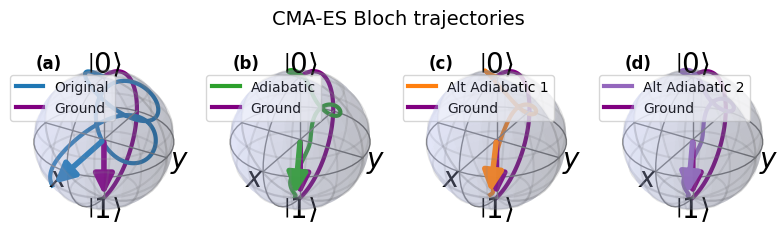

In [11]:
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# --- helper: render one row of Bloch spheres into provided axes ---
def _render_bloch_row(fig, axes_row, algorithm: str):
    for idx, target in enumerate(TARGETS):
        ax = axes_row[idx]
        handles, labels = [], []

        trajectory = simulate_bloch_trajectory(algorithm, target)
        if trajectory is None:
            ax.set_axis_off()
            ax.text2D(0.5, 0.5, 'Missing data', transform=ax.transAxes,
                      ha='center', va='center')
            continue

        bloch = qt.Bloch(fig=fig, axes=ax)
        line_width = [3, 3]
        bloch.sphere_color = '#b7c0f342'
        bloch.point_color = [GROUND_COLOR, color_for_target(target)]
        bloch.point_marker = ['o', 'o']
        bloch.point_size = [0, 0]
        bloch.vector_color = [GROUND_COLOR, color_for_target(target)]
        bloch.vector_width = 4
        bloch.vector_mutation = 30

        bloch.add_points([trajectory['ground_sx'], trajectory['ground_sy'], trajectory['ground_sz']], meth='l')
        bloch.add_points([trajectory['sx'], trajectory['sy'], trajectory['sz']], meth='l')
        bloch.add_vectors([trajectory['ground_sx'][-1], trajectory['ground_sy'][-1], trajectory['ground_sz'][-1]])
        bloch.add_vectors([trajectory['sx'][-1], trajectory['sy'][-1], trajectory['sz'][-1]])
        bloch.render()

        for i, line in enumerate(ax.lines[2:4]):
            line.set_linewidth(line_width[i])

        handles.append(Line2D([0], [0], color=color_for_target(target), lw=line_width[0], linestyle='-'))
        handles.append(Line2D([0], [0], color=GROUND_COLOR, lw=line_width[1], linestyle='-'))
        labels.append(display_name(target))
        labels.append('Ground')
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(-0.1, 0.95), fontsize=10)

# --- single-row figure for CMA-ES ---
ncols = len(TARGETS)
combined_fig = plt.figure(figsize=(8.0, 2.6))
gs = GridSpec(1, ncols, figure=combined_fig)
axes_row = [combined_fig.add_subplot(gs[0, j], projection='3d') for j in range(ncols)]

_render_bloch_row(combined_fig, axes_row, 'CMA-ES')

for i, ax in enumerate(axes_row):
    label = f"({chr(97 + i)})"
    ax.text2D(0.1, 0.95, label, transform=ax.transAxes, fontsize=12, fontweight='bold')

combined_fig.text(0.5, 0.98, 'CMA-ES Bloch trajectories', ha='center', va='top', fontsize=14)
combined_fig.tight_layout(rect=[0, 0, 1, 0.94])

combined_path_png = OUTPUT_DIR / 'bloch_trajectories_cma_es_row.png'
combined_path_pdf = OUTPUT_DIR / 'bloch_trajectories_cma_es_row.pdf'
combined_fig.savefig(combined_path_png, dpi=300, bbox_inches='tight')
combined_fig.savefig(combined_path_pdf, dpi=300, bbox_inches='tight')
print(f'Saved CMA-ES Bloch row to {combined_path_png}')
print(f'Saved CMA-ES Bloch row to {combined_path_pdf}')


In [12]:
# Compute infidelity heatmaps for CMA-ES pulses (100x100 grid)
if 'resampled_pulses' not in globals():
    raise RuntimeError('Run the pulse processing cell before computing heatmaps.')

AREA_PI_GRID = np.linspace(0.1, 6.0, 100)
# Determine global detuning span across all pulses (rad/us)
detuning_max = 0
for algorithm_dict in resampled_pulses.values():
    for target_entry in algorithm_dict.values():
        detuning_max = max(detuning_max, np.max(np.abs(target_entry['delta'])))
if detuning_max <= 0.0:
    detuning_max = 0.1
DETUNING_GRID = np.linspace(-detuning_max * 0.5, detuning_max * 0.5, 101)

solver_options = qt.Options(atol=1e-7, rtol=1e-7, nsteps=1000, store_states=False)

heatmap_results = {
    'grid': {
        'area_pi': AREA_PI_GRID,
        'detuning': DETUNING_GRID,
    },
    'data': {'CMA-ES': {}},
}

for algorithm in ['CMA-ES']:
    algorithm_pulses = resampled_pulses.get(algorithm, {})
    for target in TARGETS:
        entry = algorithm_pulses.get(target)
        if entry is None:
            continue
        omega = np.asarray(entry['omega'], dtype=float)
        delta = np.asarray(entry['delta'], dtype=float)

        area_nom = float(np.trapezoid(omega, CANONICAL_T))
        if np.isclose(area_nom, 0.0):
            raise ValueError(f'Omega area is zero for {algorithm} | {target}.')
        omega_unit = omega / area_nom  # area = 1

        heat = np.empty((DETUNING_GRID.size, AREA_PI_GRID.size), dtype=float)

        for i_det, det_shift in enumerate(DETUNING_GRID):
            delta_shifted = delta + det_shift
            delta_func = make_interpolator(delta_shifted)
            for j_area, area_pi in enumerate(AREA_PI_GRID):
                target_area = float(area_pi * np.pi)
                omega_scaled = omega_unit * target_area
                omega_func = make_interpolator(omega_scaled)
                H = [
                    [0.5 * sx, omega_func],
                    [0.5 * sz, delta_func],
                ]
                result = qt.sesolve(H, ket0, CANONICAL_T, e_ops=[proj1], options=solver_options)
                pop1 = np.clip(np.real(result.expect[0][-1]), 0.0, 1.0)
                heat[i_det, j_area] = max(1.0 - pop1, 1e-12)

        heatmap_results['data'][algorithm][target] = heat
        print(f'Computed heatmap for {algorithm} | {target}')

print('Heatmap computation complete.')


/home/yehon/projects/grape-crab-qoc/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Computed heatmap for CMA-ES | original
Computed heatmap for CMA-ES | adiabatic
Computed heatmap for CMA-ES | alt_adiabatic_1
Computed heatmap for CMA-ES | alt_adiabatic_2
Heatmap computation complete.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# --- custom colormap for log10 data -----------------------------------------
def make_flat_viridis_for_log(log_vmin, log_v1, log_v2, log_vmax, n=256):
    """
    Build a colormap for *log10-scaled images*:
      flat viridis-dark up to log_v1,
      full viridis between log_v1..log_v2,
      flat viridis-yellow above log_v2.
    Positions are specified in the [log_vmin, log_vmax] coordinate.
    """
    if not (log_vmin < log_v1 < log_v2 < log_vmax):
        raise ValueError('Require log_vmin < log_v1 < log_v2 < log_vmax')

    p1 = (log_v1 - log_vmin) / (log_vmax - log_vmin)
    p2 = (log_v2 - log_vmin) / (log_vmax - log_vmin)

    vir = plt.cm.viridis(np.linspace(0, 1, n))
    low, high = vir[0], vir[-1]

    pos_mid = p1 + (p2 - p1) * np.linspace(0, 1, n)
    pos = np.concatenate(([0.0, p1], pos_mid, [p2, 1.0]))
    cols = np.vstack([np.tile(low, (2, 1)), vir, np.tile(high, (2, 1))])

    return LinearSegmentedColormap.from_list('flat_viridis_log', list(zip(pos, cols)))
# -----------------------------------------------------------------------------

if 'heatmap_results' not in globals():
    raise RuntimeError('Run the heatmap computation cell before plotting heatmaps.')

area_pi = heatmap_results['grid']['area_pi']
detuning = heatmap_results['grid']['detuning']
X, Y = np.meshgrid(area_pi, detuning)

log_values = []
for target in TARGETS:
    heat = heatmap_results['data'].get('CMA-ES', {}).get(target)
    if heat is not None:
        log_values.append(np.log10(heat))
if not log_values:
    raise RuntimeError('No heatmap data available for plotting.')

all_logs = np.concatenate([v.ravel() for v in log_values])
log_vmin = float(np.min(all_logs))
log_vmax = float(np.max(all_logs))

log_v1, log_v2 = np.log10(1e-3), np.log10(1e-1)
flat_cmap = make_flat_viridis_for_log(log_vmin, log_v1, log_v2, log_vmax)

contour_levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
valid_levels = contour_levels[(np.log10(contour_levels) >= log_vmin) & (np.log10(contour_levels) <= log_vmax)]


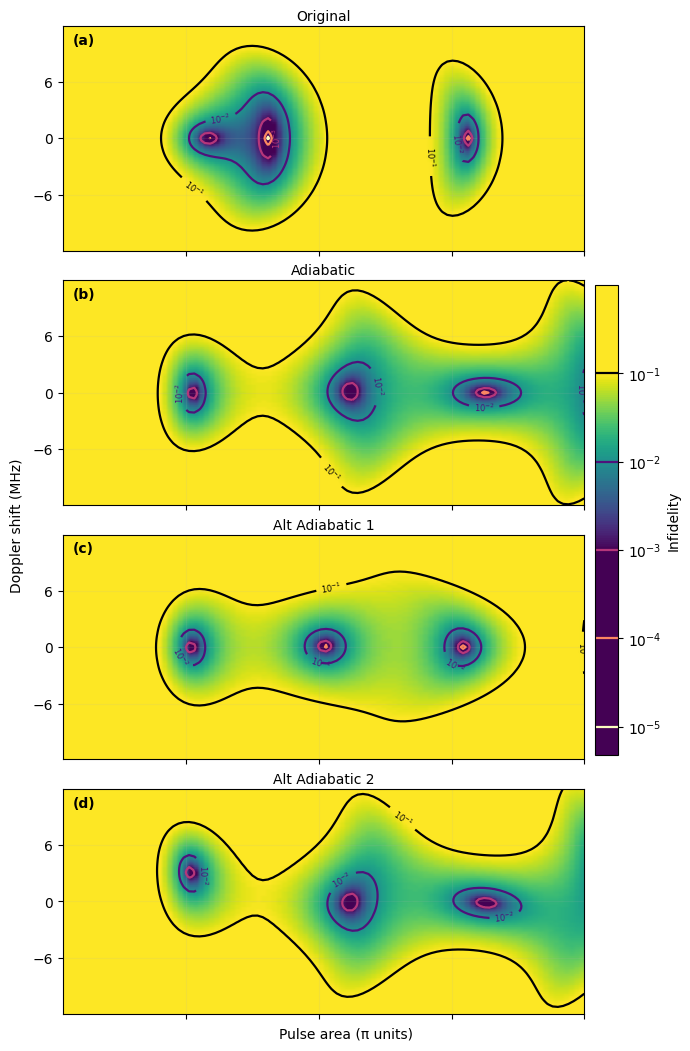

In [14]:
fig, axes = plt.subplots(len(TARGETS), 1, figsize=(6.8, 2.6 * len(TARGETS)),
                        sharex=True, sharey=True, constrained_layout=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

last_contour = None
im = None

for idx, target in enumerate(TARGETS):
    ax = axes[idx]
    heat = heatmap_results['data'].get('CMA-ES', {}).get(target)
    if heat is None:
        ax.set_axis_off()
        continue

    log_heat = np.log10(heat)
    im = ax.imshow(
        log_heat, origin='lower', aspect='auto',
        extent=[area_pi[0], area_pi[-1], detuning[0] / (2 * np.pi), detuning[-1] / (2 * np.pi)],
        cmap=flat_cmap, vmin=log_vmin, vmax=log_vmax
    )

    if valid_levels.size:
        cs = ax.contour(
            X, Y / (2 * np.pi), log_heat,
            levels=np.log10(valid_levels), cmap='magma_r', linewidths=1.6
        )
        ax.clabel(cs, fmt=lambda v: rf"$10^{{{int(round(v))}}}$", fontsize=6, inline=True)
        last_contour = cs

    ax.set_title(display_name(target), fontsize=10, pad=4)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    if idx != len(TARGETS) - 1:
        ax.set_xticklabels([])
    ax.grid(alpha=0.12)

    ax.text(0.02, 0.92, f"({chr(97 + idx)})", transform=ax.transAxes, fontsize=10, fontweight='bold')

fig.supxlabel('Pulse area (π units)', fontsize=10)
fig.supylabel('Doppler shift (MHz)', fontsize=10)

if im is None:
    raise RuntimeError('No heatmap data available for plotting.')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), location='right', fraction=0.045, pad=0.02)
tick_min = int(np.ceil(log_vmin))
tick_max = int(np.floor(log_vmax))
cbar.set_ticks(list(range(tick_min, tick_max + 1)))
cbar.set_ticklabels([rf"$10^{{{t}}}$" for t in range(tick_min, tick_max + 1)])
cbar.set_label('Infidelity', fontsize=10)

if last_contour is not None:
    cbar.add_lines(last_contour)

plt.show()


In [15]:
# save figure as png and pdf
heatmap_png_path = OUTPUT_DIR / 'infidelity_heatmaps.png'
fig.savefig(heatmap_png_path, dpi=300, bbox_inches='tight')
print(f'Saved infidelity heatmaps to {heatmap_png_path}')
heatmap_pdf_path = OUTPUT_DIR / 'infidelity_heatmaps.pdf'
fig.savefig(heatmap_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved infidelity heatmaps to {heatmap_pdf_path}')

Saved infidelity heatmaps to /home/yehon/projects/grape-crab-qoc/results/disscution/infidelity_heatmaps.png
Saved infidelity heatmaps to /home/yehon/projects/grape-crab-qoc/results/disscution/infidelity_heatmaps.pdf


In [16]:
# Cost histories for CMA-ES adiabatic variants
cma_hist_path = OUTPUT_DIR / 'cma_es_cost_histories.npz'
if not cma_hist_path.exists():
    raise FileNotFoundError('Run the CMA-ES optimization notebook to generate cost history files first.')

with np.load(cma_hist_path) as data:
    cma_histories = {key: np.asarray(data[key], dtype=float) for key in data.files}

variant_keys = ['Adiabatic', 'alt_adiabatic_1', 'alt_adiabatic_2']
fig, ax = plt.subplots(1, 1, figsize=(6.0, 3.2))

for key in variant_keys:
    if key not in cma_histories:
        continue
    values = np.clip(cma_histories[key], 1e-12, None)
    iterations = np.arange(1, values.size + 1)
    lookup_key = key.lower()
    label = display_name(lookup_key)
    color = color_for_target(lookup_key)
    ax.plot(iterations, values, label=label, color=color, linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.set_title('CMA-ES cost convergence (adiabatic variants)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(frameon=False)
plt.tight_layout()

FileNotFoundError: Run the CMA-ES optimization notebook to generate cost history files first.

In [ ]:
# Save heatmap figure as png and pdf
cost_png_path = OUTPUT_DIR / 'cost_convergence.png'
fig.savefig(cost_png_path, dpi=300, bbox_inches='tight')
print(f'Saved cost convergence figure to {cost_png_path}')
cost_pdf_path = OUTPUT_DIR / 'cost_convergence.pdf'
fig.savefig(cost_pdf_path, dpi=300, bbox_inches='tight')
print(f'Saved cost convergence figure to {cost_pdf_path}')

In [ ]:
# Runtime summary for CMA-ES adiabatic variants
cma_runtime_path = OUTPUT_DIR / 'cma_es_runtime_summary.npz'
if not cma_runtime_path.exists():
    raise FileNotFoundError('Run the CMA-ES optimization notebook to generate runtime summaries first.')

with np.load(cma_runtime_path) as data:
    cma_summary = {key: np.asarray(data[key], dtype=float) for key in data.files}

variant_keys = ['Adiabatic', 'alt_adiabatic_1', 'alt_adiabatic_2']
variant_labels = [display_name(key.lower()) for key in variant_keys]
runtimes = []
for key in variant_keys:
    entry = cma_summary.get(key)
    runtimes.append(entry[1] if entry is not None else np.nan)

for label, value in zip(variant_labels, runtimes):
    if np.isfinite(value):
        print(f'{label}: runtime={value:.2f}s')
    else:
        print(f'{label}: runtime unavailable')

x = np.arange(len(variant_keys))
colors = [color_for_target(key.lower()) for key in variant_keys]
fig, ax = plt.subplots(figsize=(6.0, 3.2))
bars = ax.bar(x, runtimes, color=colors, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(variant_labels)
ax.set_ylabel('Runtime (s)')
ax.set_title('CMA-ES runtime (2000 iterations)')
ax.grid(axis='y', linestyle='--', alpha=0.3)

finite_values = [val for val in runtimes if np.isfinite(val)]
offset = 0.01 * max(finite_values) if finite_values else 0.1
for bar, value in zip(bars, runtimes):
    if np.isfinite(value):
        ax.text(bar.get_x() + bar.get_width() / 2, value + offset, f'{value:.1f}s', ha='center', va='bottom', fontsize=9)

runtime_png = OUTPUT_DIR / 'cma_es_runtime_adiabatic_variants.png'
runtime_pdf = OUTPUT_DIR / 'cma_es_runtime_adiabatic_variants.pdf'
fig.savefig(runtime_png, dpi=300, bbox_inches='tight')
fig.savefig(runtime_pdf, bbox_inches='tight')
print(f'Saved runtime figures to {runtime_png} and {runtime_pdf}')
plt.tight_layout()
plt.show()

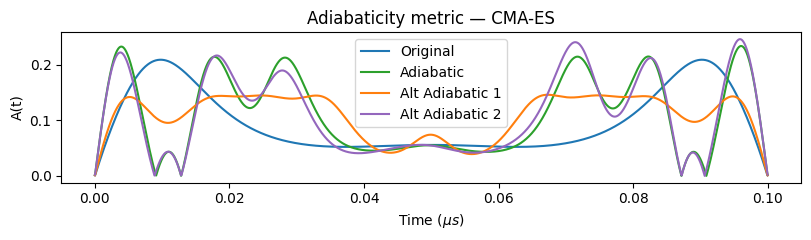

In [17]:
# Compute updated adiabaticity metric A(t) and visualize
if 'resampled_pulses' not in globals():
    raise RuntimeError('Run the pulse processing cell before computing adiabaticity.')

PLOT_COLORS = {
    'original': '#1f77b4',
    'adiabatic': '#2ca02c',
    'alt_adiabatic_1': '#ff7f0e',
    'alt_adiabatic_2': '#9467bd',
}

adiabaticity = {}
for algorithm, targets_dict in resampled_pulses.items():
    if not targets_dict:
        continue
    metrics = {}
    for target, pulse_dict in targets_dict.items():
        omega = pulse_dict['omega']
        delta = pulse_dict['delta']
        domega_dt = np.gradient(omega, CANONICAL_T)
        ddelta_dt = np.gradient(delta, CANONICAL_T)
        numerator = np.abs(delta * domega_dt - omega * ddelta_dt)
        denom = 2.0 * np.power(np.sqrt(np.clip(omega**2 + delta**2, 1e-12, None)), 3)
        with np.errstate(divide='ignore', invalid='ignore'):
            metric = np.nan_to_num(numerator / denom, nan=0.0, posinf=0.0, neginf=0.0)
        metrics[target] = metric
    adiabaticity[algorithm] = metrics

if not adiabaticity:
    print('No pulses available to compute adiabaticity.')
else:
    alg_items = list(adiabaticity.items())
    fig, axes = plt.subplots(len(alg_items), 1, figsize=(8.3, 2.5 * len(alg_items)), sharex=True)
    if len(alg_items) == 1:
        axes = [axes]
    for ax, (algorithm, metrics) in zip(axes, alg_items):
        for target, metric in metrics.items():
            ax.plot(CANONICAL_T, metric, label=display_name(target), color=PLOT_COLORS.get(target, '#333333'))
        ax.set_ylabel('A(t)')
        ax.set_title(f'Adiabaticity metric — {algorithm}')
        ax.legend()
    axes[-1].set_xlabel(TIME_LABEL)
    plt.tight_layout()